

```
# This is formatted as code
```

#**Luka Foy - 99670210**

version 1.0.1
#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Web Server Log Analysis with Apache Spark**
 
####This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.
 
####Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

### How to complete this assignment
 
####This assignment is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing. For each problem, you should start by thinking about the algorithm that you will use to *efficiently* process the log in a parallel, distributed manner. This means using the various [RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) operations along with [`lambda` functions](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) that are applied at each worker.
 
####This assignment consists of 4 parts:
#### *Part 1*: TSV Log file format [0 points]
#### *Part 2*: Sample Analyses on the Web Server Log File  [0 points]
#### *Part 3*: Analyzing a Web Server Log File  [45 points]
#### *Part 4*: Exploring 404 Response Codes  [45 points]

In [117]:
# Uncomment to install the Spark context
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

import os
os.environ['PYTHONHASHSEED']="0"
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
spark = SparkSession.builder.master("local[*]").appName('SparkExample').config(
    "spark.executor.memory", "1g").config(
        "spark.executorEnv.PYTHONHASHSEED","0").config("spark.ui.port", "4050"
        ).getOrCreate()
sc = spark.sparkContext


# A few additional libraries we will need
from math import sqrt

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)
    

import unittest
Test = unittest.TestCase()

### **Part 1: Log file format**
####The log file that we use for this assignment is in the TSV format (tab separated values). The log file entries produced in TSV will look something like this:
`piweba3y.prodigy.com - 807301196 GET /shuttle/missions/missions.html 200 8677`
 
####Each part of this log entry is described below.
* `piweba3y.prodigy.com`
####This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
 
* `-`
####The "hyphen" in the output indicates that the requested piece of information (log name) is not available.
 
* `807301196`
####The time that the server finished processing the request in seconds since 1970 (The Unix epoch (or Unix time or POSIX time or Unix timestamp))

* `GET`
####The request method (e.g., `GET`, `POST`, etc.), 

* `/shuttle/missions/missions.html`
The endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier)), which is the requested path
 
* `200`
####This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `8677`
####The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).
 
####Note that log files contain information supplied directly by the client, without escaping. Therefore, it is possible for malicious clients to insert control-characters in the log files, *so care must be taken in dealing with raw logs.*
 
### NASA-HTTP Web Server Log
####For this assignment, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz) and contains two month's of all HTTP requests. We are using a subset that only contains several days worth of requests.

In [118]:
#download the special subset
# !gdown 'https://drive.google.com/uc?export=download&confirm=t&id=16m335JAibvlV2fQbOylznGF30qTLvbmn'
import urllib.request
url = 'https://drive.google.com/uc?export=download&confirm=t&id=16m335JAibvlV2fQbOylznGF30qTLvbmn'
filename = 'nasa_19950801.tsv'
urllib.request.urlretrieve(url, filename)

('nasa_19950801.tsv', <http.client.HTTPMessage at 0x7fc06cc38fd0>)

### **(1a) Parsing Each Log Line**
####Using the TSV as defined above, we create a function that parses a line and returns a pair consisting of a Row object and 1. If the log line fails to match the regular expression, the function returns a pair consisting of the log line string and 0. A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the log line's date string into a Python `datetime` object using the given `parse_apache_time` function.

In [119]:
import re
import datetime

from pyspark.sql import Row

def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = logline.split('\t')
    try:
      size_field = match[6]
      if size_field == '-':
          size = int(0)
      else:
          size = int(match[6])
      return (Row(
          host          = match[0],
          log_name      = match[1],
          date_time     = datetime.datetime.utcfromtimestamp(int(match[2])),
          method        = match[3],
          endpoint      = match[4],
          response_code = int(match[5]),
          content_size  = size
      ), 1)
    except:
      return (logline, 0)


### **(1b) Configuration and Initial RDD Creation**
####We are ready to specify the input log file and create an RDD containing the parsed log file data. The log file has already been downloaded for you.
 
####To create the primary RDD that we'll use in the rest of this assignment, we first load the text file using [`sc.textfile(logFile)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile) to convert each line of the file into an element in an RDD.
####Next, we use [`map(parseLog)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) to apply the parse function to each element (that is, a line from the log file) in the RDD and turn each line into a pair [`Row` object](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row).
####Finally, we cache the RDD in memory since we'll use it throughout this notebook.

In [120]:

def parseLog(logFile):
    parsed_log = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_log
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_log
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid logline: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)

    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_log.count(), access_logs.count(), failed_logs.count()))
    return parsed_log, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLog('nasa_19950801.tsv')

Number of invalid logline: 1
Invalid logline: host	logname	time	method	url	response	bytes	referer	useragent
Read 30970 lines, successfully parsed 30969 lines, failed to parse 1 lines


### **Part 2: Sample Analyses on the Web Server Log File**
 
####Now that we have an RDD containing the log file as a set of Row objects, we can perform various analyses.
 
#### **(2a) Example: Content Size Statistics**
 
####Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.
 
####We can compute the statistics by applying a `map` to the `access_logs` RDD. The `lambda` function we want for the map is to extract the `content_size` field from the RDD. The map produces a new RDD containing only the `content_sizes` (one element for each Row object in the `access_logs` RDD). To compute the minimum and maximum statistics, we can use [`min()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.min) and [`max()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.max) functions on the new RDD. We can compute the average statistic by using the [`reduce`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce) function with a `lambda` function that sums the two inputs, which represent two elements from the new RDD that are being reduced together. The result of the `reduce()` is the total content size from the log and it is to be divided by the number of requests as determined using the [`count()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) function on the new RDD.

In [121]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))

Content Size Avg: 15563, Min: 0, Max: 1269716


#### **(2b) Example: Response Code Analysis**
####Next, lets look at the response codes that appear in the log. As with the content size analysis, first we create a new RDD by using a `lambda` function to extract the `response_code` field from the `access_logs` RDD. The difference here is that we will use a [pair tuple](https://docs.python.org/2/tutorial/datastructures.html?highlight=tuple#tuples-and-sequences) instead of just the field itself. Using a pair tuple consisting of the response code and 1 will let us count how many records have a particular response code. Using the new RDD, we perform a [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) function. `reduceByKey` performs a reduce on a per-key basis by applying the `lambda` function to each element, pairwise with the same key. We use the simple `lambda` function of adding the two values. Then, we cache the resulting RDD and create a list by using the [`take`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) function.

In [122]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print('Found %d response codes' % len(responseCodeToCountList))
print('Response Code Counts: %s' % sorted(responseCodeToCountList))
assert len(responseCodeToCountList) == 4
assert sorted(responseCodeToCountList) == [(200, 27972), (302, 355), (304, 2421), (404, 221)]

Found 4 response codes
Response Code Counts: [(200, 27972), (302, 355), (304, 2421), (404, 221)]


#### **(2c) Example: Response Code Graphing with `matplotlib`**
####Now, lets visualize the results from the last example. We can visualize the results from the last example using [`matplotlib`](http://matplotlib.org/). First we need to extract the labels and fractions for the graph. We do this with two separate `map` functions with a `lambda` functions. The first `map` function extracts a list of of the response code values, and the second `map` function extracts a list of the per response code counts  divided by the total size of the access logs. Next, we create a figure with `figure()` constructor and use the `pie()` method to create the pie plot.

In [123]:
labels = responseCodeToCount.map(lambda xy: xy[0]).collect()
print(labels)
count = access_logs.count()
fracs = responseCodeToCount.map(lambda xy: (float(xy[1]) / count)).collect()
print(fracs)

[200, 304, 302, 404]
[0.9032258064516129, 0.07817494914269107, 0.011463075979205012, 0.0071361684264910075]


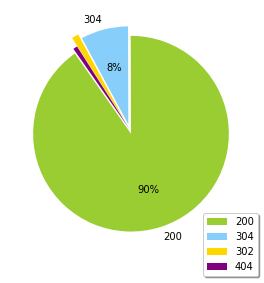

In [124]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', ]
explode = (0.05, 0.05, 0.1, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)


#### **(2d) Example: Frequent Hosts**
####Let's look at hosts that have accessed the server multiple times (e.g., more than ten times). As with the response code analysis in (2b), first we create a new RDD by using a `lambda` function to extract the `host` field from the `access_logs` RDD using a pair tuple consisting of the host and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then filter the result based on the count of accesses by each host (the second element of each pair) being greater than ten. Next, we extract the host name by performing a `map` with a `lambda` function that returns the first element of each pair. Finally, we extract 20 elements from the resulting RDD - *note that the choice of which elements are returned is not guaranteed to be deterministic.*

In [125]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print('Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20)
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have accessed more then 10 times: ['bettong.client.uq.oz.au', 'dd10-046.compuserve.com', 'rvr0151.deltanet.com', '202.30.120.241', 'www-a1.proxy.aol.com', 'ad03-053.compuserve.com', 'www-b3.proxy.aol.com', 'dialup12.leuven.eunet.be', '193.84.66.147', 'gwa.ericsson.com', '198.189.70.111', 'www-d4.proxy.aol.com', 'pc-heh.icl.dk', 'www-b2.proxy.aol.com', 'beglinger.dial-up.bdt.com', 'dialup21.brussels.eunet.be', 'mage.ho.bom.gov.au', '204.96.24.4', 'nevans.aom.bt.co.uk', 'alyssa.prodigy.com']


#### **(2e) Example: Visualizing Endpoints**
####Now, lets visualize the number of hits to endpoints (URIs) in the log. To perform this task, we first create a new RDD by using a `lambda` function to extract the `endpoint` field from the `access_logs` RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then cache the results.
 
####Next we visualize the results using `matplotlib`. We previously imported the `matplotlib.pyplot` library, so we do not need to import it again. We perform two separate `map` functions with `lambda` functions. The first `map` function extracts a list of endpoint values, and the second `map` function extracts a list of the visits per endpoint values. Next, we create a figure with `figure()` constructor, set various features of the plot (axis limits, grid lines, and labels), and use the `plot()` method to create the line plot.

<ipython-input-126-6106bcc7ba3a>:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', axis='y')


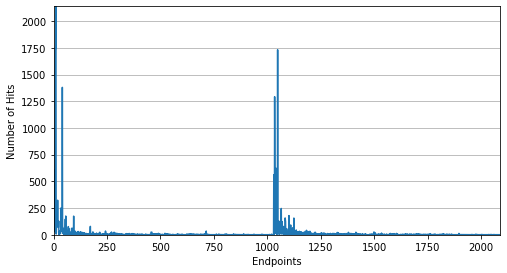

In [126]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda xy: xy[0]).collect()
counts = endpoints.map(lambda xy: xy[1]).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)

#### **(2f) Example: Top Endpoints**
####For the final example, we'll look at the top endpoints (URIs) in the log. To determine them, we first create a new RDD by using a `lambda` function to extract the `endpoint` field from the `access_logs` RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then extract the top ten endpoints by performing a [`takeOrdered`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered) with a value of 10 and a `lambda` function that multiplies the count (the second element of each pair) by -1 to create a sorted list with the top endpoints at the bottom.

In [127]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print('Top Ten Endpoints: %s' % topEndpoints)
assert topEndpoints == [('/images/NASA-logosmall.gif', 2140), ('/images/MOSAIC-logosmall.gif', 1756), ('/images/USA-logosmall.gif', 1748), ('/images/WORLD-logosmall.gif', 1734), ('/images/ksclogo-medium.gif', 1727), ('/ksc.html', 1382), ('/images/KSC-logosmall.gif', 1294), ('/', 627), ('/history/apollo/images/apollo-logo1.gif', 606), ('/images/launch-logo.gif', 562)]

Top Ten Endpoints: [('/images/NASA-logosmall.gif', 2140), ('/images/MOSAIC-logosmall.gif', 1756), ('/images/USA-logosmall.gif', 1748), ('/images/WORLD-logosmall.gif', 1734), ('/images/ksclogo-medium.gif', 1727), ('/ksc.html', 1382), ('/images/KSC-logosmall.gif', 1294), ('/', 627), ('/history/apollo/images/apollo-logo1.gif', 606), ('/images/launch-logo.gif', 562)]


### **Part 3: Analyzing Web Server Log File**
 
####Now it is your turn to perform analyses on web server log files.

#### **(3a) Exercise: Top Ten Error Endpoints  [10 points]**
####What are the top ten endpoints which did not have return code 200? Create a sorted list containing top ten endpoints and the number of times that they were accessed with non-200 return code.
 
####Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints, and sort the list.
 
####You might want to refer back to the previous Lab (Lab 0) for insights.

In [128]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Each of these <FILL IN> below could be completed with a single transformation or action.
# You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined (ie. endpointSum, topTenErrURLs).

not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b: a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])

print('Top Ten failed URLs: %s' % endpointSum)

print(topTenErrURLs)


Top Ten failed URLs: PythonRDD[876] at RDD at PythonRDD.scala:53
[('/images/NASA-logosmall.gif', 268), ('/images/KSC-logosmall.gif', 210), ('/images/MOSAIC-logosmall.gif', 172), ('/images/USA-logosmall.gif', 168), ('/images/ksclogo-medium.gif', 160), ('/images/WORLD-logosmall.gif', 153), ('/', 84), ('/images/Nasa-logo.gif', 79), ('/history/apollo/images/apollo-logo1.gif', 62), ('/images/launch-logo.gif', 57)]


In [129]:
print(access_logs.take(1))

[Row(host='pppa006.compuserve.com', log_name='-', date_time=datetime.datetime(1995, 8, 1, 6, 0), method='GET', endpoint='/images/launch-logo.gif', response_code=200, content_size=1713)]


In [130]:
# TEST Top ten error endpoints (3a)
Test.assertEqual(endpointSum.count(), 581, 'incorrect count for endpointSum')
Test.assertEqual(topTenErrURLs, [('/images/NASA-logosmall.gif', 268), ('/images/KSC-logosmall.gif', 210), ('/images/MOSAIC-logosmall.gif', 172), ('/images/USA-logosmall.gif', 168), ('/images/ksclogo-medium.gif', 160), ('/images/WORLD-logosmall.gif', 153), ('/', 84), ('/images/Nasa-logo.gif', 79), ('/history/apollo/images/apollo-logo1.gif', 62), ('/images/launch-logo.gif', 57)])

#### **(3b) Exercise: Number of Unique Hosts [10 points]**
####How many unique hosts are there in the entire log?
 
####Think about the steps that you need to perform to count the number of different hosts in the log.

In [131]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Do you recall the tips from (3a)? Each of these <FILL IN> could be an transformation or action.

hosts = access_logs.map(lambda log: (log.host, 0))

uniqueHosts = hosts.reduceByKey(lambda a, b : a + b)

uniqueHostCount = uniqueHosts.count()

print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 2365


In [132]:
# TEST Number of unique hosts (3b)
Test.assertEqual(uniqueHostCount, 2365, 'incorrect uniqueHostCount')

#### **(3c) Exercise: Number of Unique Hourly Hosts [10 points]**
####For an advanced exercise, let's determine the number of unique hosts in the entire log on a hour-by-hour basis. This computation will give us counts of the number of unique hourly hosts. We'd like a list sorted by increasing hour which includes the hour and the associated number of unique hosts for that hour. Make sure you cache the resulting RDD `hourlyHosts` so that we can reuse it in the next exercise.
 
####Think about the steps that you need to perform to count the number of different hosts that make requests *each* hour.
####*Note, the log only covers a single day.*

In [133]:
# TODO: Replace <FILL IN> with appropriate code

hourToHostPairTuple = access_logs.map(lambda log: (((log.host, log.date_time.hour)), 1))

uniqueHourToHostPairTuple = hourToHostPairTuple.reduceByKey(lambda a, b : a + b)

hourTuple = uniqueHourToHostPairTuple.map(lambda log: (log[0][1], 1))

hourlyHosts = hourTuple.reduceByKey(lambda a, b : a + b).cache()

hourlyHostsList = hourlyHosts.sortBy(lambda x: x[0]).collect()


In [134]:
# TEST Number of unique daily hosts (3c)
Test.assertEqual(hourlyHosts.count(), 13, 'incorrect hourlyHosts.count()')
Test.assertEqual(hourlyHostsList, [(6, 115), (7, 123), (8, 95), (9, 114), (10, 114), (11, 177), (12, 279), (13, 343), (14, 415), (15, 397), (16, 444), (17, 357), (18, 273)], 'incorrect hourlyHostsList')
Test.assertTrue(hourlyHosts.is_cached, 'incorrect hourlyHosts.is_cached')

#### **(3d) Challenge: Find How Much Data was from images [15 points]**
####For a challenge, let's determine the amount of data sent from the server to hosts that was due to images and compare it to the amount of data sent for everything else. This computation gives us an idea about whether we should more aggressively downsample or compress the images on our website so that we reduce the amount of data we send.

In [135]:
import os
def get_extension(fullpath):
  """
  Returns just the extension of the full path.
  For example, '/path/to/somefile.ext' -> '.ext'
  """
  filename, file_extension = os.path.splitext(fullpath)
  return file_extension

#common image types
IMAGES = {'.ras', '.xwd', '.bmp', '.jpe', '.jpg', '.jpeg', '.xpm', '.ief', '.pbm', '.tif', '.gif', '.ppm', '.xbm', '.tiff', '.rgb', '.pgm', '.png', '.pnm'}

images = access_logs.filter(lambda log: get_extension(log.endpoint) in IMAGES)

imageBytes = images.map(lambda log: log.content_size).sum()


nonImages = access_logs.filter(lambda log: get_extension(log.endpoint) not in IMAGES)

nonImageBytes = nonImages.map(lambda log: log.content_size).sum()




In [136]:
print('Non image total bytes sent: %s' % nonImageBytes)
print('Image total bytes sent: %s' % imageBytes)
Test.assertEqual(nonImageBytes, 248771434, 'incorrect nonImageBytes')
Test.assertEqual(imageBytes, 233229033, 'imageBytes')


Non image total bytes sent: 248771434
Image total bytes sent: 233229033


### **Part 4: Exploring 404 Response Codes**
 
####Let's drill down and explore the error 404 response code records. 404 errors are returned when an endpoint is not found by the server (i.e., a missing page or object).

#### **(4a) Exercise: Counting 404 Response Codes [10 points]**
#### Create a RDD containing only log records with a 404 response code. Make sure you `cache()` the RDD `badRecords` as we will use it in the rest of this exercise.
 
#### How many 404 records are in the log?

In [137]:
# TODO: Replace <FILL IN> with appropriate code

badRecords = (access_logs.filter(lambda log: log.response_code == 404))
badRecords.cache()
print('Found %d 404 URLs' % badRecords.count())

Found 221 404 URLs


In [138]:
# TEST Counting 404 (4a)
Test.assertEqual(badRecords.count(), 221, 'incorrect badRecords.count()')
Test.assertTrue(badRecords.is_cached, 'incorrect badRecords.is_cached')

#### **(4b) Exercise: Listing 404 Response Code Records [10 points]**
####Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list up to 40 **distinct** endpoints that generate 404 errors -  *no endpoint should appear more than once in your list.*

In [139]:
# TODO: Replace <FILL IN> with appropriate code

badEndpoints = badRecords.map(lambda log: log.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print('404 URLS: %s' % badUniqueEndpointsPick40)

404 URLS: ['/shuttle/resources/orbiters/atlantis.gif', '/history/apollo/html', '/images/Nasa-logo.gif', '/nasa/nasa_hottopics.html', '/people/nasa-cm/jmd.html', '/IUMA/lib/htu_button.gif', '/shuttle/technology/sts_newsreflsts_ovcomm.html', '/l', '/history/apollo/sa-1/images/', '/history/apollo/sa-1/docs/', '/history/apollo/sa-9/images/', '/history/apollo/sa-9/news/', '/nws/public', '/elv/new01.gif', '/shuttle/technology/images/sts-comm.jpg', '/shuttle/technology/sts-newsref/spacelab', '/shuttle/missions/sts-68/ksc-upclose.gif', '/ksc.html0.', '/SDG/Experimental/demoweb/return.gif', '/shuttle/missions-sts-49.html', '/ksclogo-medium.gif', '/ksc.nasa.gov/images/ksclogo-medium.gif', '/shuttle/missions/sts-69/images/KSC-95EC-1014.gif', '/shuttle/missions/sts-69/images/KSC-95EC-0852.gif', '/shuttle/missions/STS-69/images/index69.gif', '/://spacelink.msfc.nasa.gov', '/robots.txt', '/shuttle/missions/sts-71/count71.gif', '/history/apollo/sa-5/sa-5-patch-small.gif', '/history/apollo/sa-5/sounds

In [141]:
# TEST Listing 404 records (4b)

badUniqueEndpointsSet40 = set(badUniqueEndpointsPick40)
Test.assertEqual(len(badUniqueEndpointsSet40), 40, 'badUniqueEndpointsPick40 not distinct')



#### **(4c) Exercise: Listing the Top Twenty 404 Response Code Endpoints [10 points]**
####Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list of the top twenty endpoints that generate the most 404 errors.
####*Remember, top endpoints should be in sorted order*

In [142]:
# TODO: Replace <FILL IN> with appropriate code

badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a, b: a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, key=lambda x: -x[1])

print('Top Twenty 404 URLs: %s' % badEndpointsTop20)

Top Twenty 404 URLs: [('/images/Nasa-logo.gif', 79), ('/pub/winvn/readme.txt', 14), ('/pub/winvn/release.txt', 12), ('/elv/DELTA/uncons.htm', 10), ('/M/on-this-day', 6), ('/shuttle/missions/STS-69/images/index69.gif', 4), ('/history/apollo/sa-1/sa-1-patch-small.gif', 4), ('/pub', 4), ('/shuttle/resources/orbiters/atlantis.gif', 3), ('/shuttle/resources/orbiters/discovery.gif', 3), ('/history/apollo/sa-9/sa-9-patch-small.gif', 3), ('/shuttle/technology/images/sts-comm-small.gif', 3), ('/nasa/nasa_hottopics.html', 2), ('/people/nasa-cm/jmd.html', 2), ('/shuttle/technology/sts_newsreflsts_ovcomm.html', 2), ('/elv/new01.gif', 2), ('/shuttle/technology/sts-newsref/spacelab', 2), ('/shuttle/missions/sts-68/ksc-upclose.gif', 2), ('/ksc.html0.', 2), ('/://spacelink.msfc.nasa.gov', 2)]


In [143]:
# TEST Top twenty 404 URLs (4c)
Test.assertEqual(badEndpointsTop20, [('/images/Nasa-logo.gif', 79), ('/pub/winvn/readme.txt', 14), ('/pub/winvn/release.txt', 12), ('/elv/DELTA/uncons.htm', 10), ('/M/on-this-day', 6), ('/shuttle/missions/STS-69/images/index69.gif', 4), ('/history/apollo/sa-1/sa-1-patch-small.gif', 4), ('/pub', 4), ('/shuttle/resources/orbiters/atlantis.gif', 3), ('/shuttle/resources/orbiters/discovery.gif', 3), ('/history/apollo/sa-9/sa-9-patch-small.gif', 3), ('/shuttle/technology/images/sts-comm-small.gif', 3), ('/nasa/nasa_hottopics.html', 2), ('/people/nasa-cm/jmd.html', 2), ('/shuttle/technology/sts_newsreflsts_ovcomm.html', 2), ('/elv/new01.gif', 2), ('/shuttle/technology/sts-newsref/spacelab', 2), ('/shuttle/missions/sts-68/ksc-upclose.gif', 2), ('/ksc.html0.', 2), ('/://spacelink.msfc.nasa.gov', 2)])

#### **(4d) Challenge: Find Case Sensitive 404s [15 points]**
####For a challenge, let's determine which page requests were for pages that are on the server (pages whose response code was a successful 200) but were requested incorrectly because of letter case sensitivity. For example, requesting '/images/Nasa-logo.gif' instead of '/images/nasa-logo.gif' would result in a 404 error because a file with the image would fail to be found with a capital N. This could give us debugging information for how to fix a different web page that incorrectly referenced '/images/Nasa-logo.gif'.


In [144]:
# you need to fully structure code (multiple lines) here
# HINT: you should use two RDDs together

response200 = access_logs.filter(lambda log: log.response_code == 200)

all200Endpoints = response200.map(lambda log: log.endpoint.lower()).distinct()

all404Endpoints = badRecords.map(lambda log: log.endpoint.lower()).distinct()

caseSensitive404s = all200Endpoints.intersection(all404Endpoints).sortBy(lambda x: x)

In [145]:
Test.assertEqual(caseSensitive404s.collect(), ['/elv/new01.gif', '/history/apollo/apollo-13/apollo-13.html', '/images/nasa-logo.gif', '/mdss/', '/shuttle/missions/sts-69/images/index69.gif', '/shuttle/missions/sts-71/count71.gif'],
                 'incorrect case sensitive 404s')